In [1]:
!pip install demoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import demoji
from transformers import pipeline,BertModel,BertTokenizer,get_linear_schedule_with_warmup
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


df = pd.read_csv("/kaggle/input/fake-job-postings/Fake Postings.csv",delimiter=',')
df.head(10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
cpu


title  \
0                           Mental health nurse   
1                     Conference centre manager   
2                                Engineer, land   
3                       Forest/woodland manager   
4  Production designer, theatre/television/film   
5                              Insurance broker   
6                       Presenter, broadcasting   
7                      Surveyor, land/geomatics   
8                   Production assistant, radio   
9                             Ceramics designer   

                                         description  \
0  Arm drive court sure vote. Earn $5000/week! Im...   
1  Government whom its bed go tax tree black. Ear...   
2  I member discuss follow way there nation. Earn...   
3  House across wait approach face. Earn $5000/we...   
4  Case best environmental full finally leader me...   
5  That page party sell student cultural despite....   
6  Evidence always item increase partner necessar...   
7  Country situation skin. Earn $5000/week! Immed...   
8  Song role during democratic. Earn $5000/week! ...   
9  Nor upon style audience. Earn $5000/week! Imme...   

                                        requirements  \
0  Basic knowledge in live, no degree required. F...   
1  Basic knowledge in seek, no degree required. F...   
2  Basic knowledge in worker, no degree required....   
3  Basic knowledge in example, no degree required...   
4  Basic knowledge in smile, no degree required. ...   
5  Basic knowledge in section, no degree required...   
6  Basic knowledge in interest, no degree require...   
7  Basic knowledge in front, no degree required. ...   
8  Basic knowledge in beautiful, no degree requir...   
9  Basic knowledge in rise, no degree required. F...   

                                    company_profile           location  \
0               Rivera and Sons - Established 2022.       West Jeffrey   
1     Davidson, Jones and Gomez - Established 2003.  Lake Meredithberg   
2                     Allen Ltd - Established 1998.     Lake Cathybury   
3                    Forbes Ltd - Established 1990.  South Matthewstad   
4  Jennings, Martin and Sanchez - Established 1975.    East Rhondafurt   
5                  Rice-Johnson - Established 2015.          Wrightton   
6                   Singh Group - Established 1979.        Bridgetbury   
7                 Bridges Group - Established 1993.           Carltown   
8     Thomas, Powers and Garcia - Established 1978.     North Lisastad   
9      Wilson, Owens and Watson - Established 1974.       Brittanyside   

     salary_range employment_type    industry                   benefits  \
0  $55016-$100476      Internship          IT                 Free meals   
1   $53438-$93138       Part-Time     Finance             Flexible hours   
2  $45584-$105229       Part-Time          IT                Free travel   
3  $66188-$139621       Full-Time   Education                Free travel   
4  $32183-$115012       Temporary      Retail             Flexible hours   
5  $61975-$109632      Internship  Healthcare              Sign-on bonus   
6   $45072-$97862       Part-Time  Automotive             Flexible hours   
7   $38362-$75264       Part-Time  Automotive              Sign-on bonus   
8  $48317-$134017      Internship  Automotive  Remote work opportunities   
9   $61374-$89783       Temporary          IT  Remote work opportunities   

   fraudulent  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1  
8           1  
9           1

In [2]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.dtypes)
print(df.nunique())

title              0
description        0
requirements       0
company_profile    0
location           0
salary_range       0
employment_type    0
industry           0
benefits           0
fraudulent         0
dtype: int64
0
title              object
description        object
requirements       object
company_profile    object
location           object
salary_range       object
employment_type    object
industry           object
benefits           object
fraudulent          int64
dtype: object
title                639
description        10000
requirements         971
company_profile     9953
location             100
salary_range       10000
employment_type        5
industry               8
benefits               5
fraudulent             1
dtype: int64


In [3]:
### useing 'Text' as all text data combined

df['Text'] = df['title'] + df['requirements'] + df['description']



def clean_text(text):

    text = str(text).lower()
    text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)', '',text)

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'#(\w+)','',text)

    text = demoji.replace(text,'')


    text = re.sub(r'[^\w\s]', '',text)

    text = re.sub(r'\@w+|\#','',text)






    return text



df['Text'] = df['Text'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)
df['Text'].head(10)

0    mental health nursebasic knowledge in live no ...
1    conference centre managerbasic knowledge in se...
2    engineer landbasic knowledge in worker no degr...
3    forestwoodland managerbasic knowledge in examp...
4    production designer theatretelevisionfilmbasic...
5    insurance brokerbasic knowledge in section no ...
6    presenter broadcastingbasic knowledge in inter...
7    surveyor landgeomaticsbasic knowledge in front...
8    production assistant radiobasic knowledge in b...
9    ceramics designerbasic knowledge in rise no de...
Name: Text, dtype: object

In [4]:

sw = set(stopwords.words("english"))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)



df['description'] = df['description'].apply(remove_stopwords)
df['description'].head(10)

0    arm drive court sure vote earn 5000week immedi...
1    government bed go tax tree black earn 5000week...
2    member discuss follow way nation earn 5000week...
3    house across wait approach face earn 5000week ...
4    case best environmental full finally leader ea...
5    page party sell student cultural despite earn ...
6    evidence always item increase partner necessar...
7    country situation skin earn 5000week immediate...
8    song role democratic earn 5000week immediate h...
9    upon style audience earn 5000week immediate hi...
Name: description, dtype: object

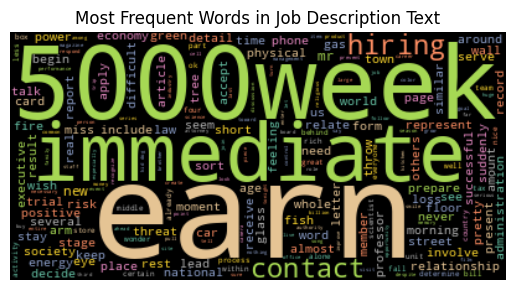

In [5]:
### only doing this for description feature
description_txt = " ".join(i for i in df['description'])

wc = WordCloud(colormap="Set2",collocations=False).generate(description_txt)
plt.title("Most Frequent Words in Job Description Text")
plt.axis("off")
plt.imshow(wc,interpolation='bilinear')
plt.show()


In [6]:
# for most common words in job descriptions

blob = TextBlob(description_txt).words

most_common_words = nltk.FreqDist(blob).most_common(50)
print(f'top 50 most common words from job descriptions: {most_common_words}')

top 50 most common words from job descriptions: [('earn', 10000), ('5000week', 10000), ('immediate', 10000), ('hiring', 10000), ('contact', 10000), ('prepare', 83), ('seem', 76), ('energy', 76), ('relationship', 76), ('stage', 75), ('pretty', 74), ('lead', 74), ('suddenly', 74), ('executive', 73), ('phone', 73), ('time', 73), ('involve', 73), ('almost', 73), ('physical', 72), ('national', 72), ('loss', 72), ('positive', 72), ('relate', 72), ('car', 72), ('place', 71), ('talk', 71), ('include', 71), ('stay', 71), ('fish', 71), ('power', 71), ('morning', 71), ('threat', 71), ('moment', 71), ('never', 71), ('economy', 71), ('arm', 70), ('page', 70), ('glass', 70), ('decide', 70), ('whole', 70), ('wall', 70), ('represent', 70), ('word', 70), ('trial', 70), ('amount', 70), ('green', 70), ('street', 70), ('tree', 69), ('society', 69), ('gas', 69)]


In [7]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp(description_txt)

for ent in doc.ents:
    print(ent.text, "|",spacy.explain(ent.label_))




seven | Numerals that do not fall under another type
derrickbakergmailcom house | Companies, agencies, institutions, etc.
american | Nationalities or religious or political groups
hour | Times smaller than a day
four | Numerals that do not fall under another type
carol66hotmailcom | Countries, cities, states
marc83smithinfo | People, including fictional
jirwingmailcom house | Companies, agencies, institutions, etc.
half | Numerals that do not fall under another type
month | Absolute or relative dates or periods
four | Numerals that do not fall under another type
joel87baileycom | Companies, agencies, institutions, etc.
four | Numerals that do not fall under another type
third | "first", "second", etc.
republican | Nationalities or religious or political groups
four | Numerals that do not fall under another type
seven | Numerals that do not fall under another type
first | "first", "second", etc.
year court | Companies, agencies, institutions, etc.
age part decade | Absolute or relative 

In [8]:
import sqlite3 as sql
con = sql.connect("jobs.db")
df.to_sql("jobs",con,if_exists="replace",index=False)
pd.read_sql("""SELECT * FROM jobs;""",con)


title  \
0                              Mental health nurse   
1                        Conference centre manager   
2                                   Engineer, land   
3                          Forest/woodland manager   
4     Production designer, theatre/television/film   
...                                            ...   
9995                           Designer, furniture   
9996                Therapist, speech and language   
9997                             Therapist, sports   
9998                   Clinical research associate   
9999                           Hospital pharmacist   

                                            description  \
0     arm drive court sure vote earn 5000week immedi...   
1     government bed go tax tree black earn 5000week...   
2     member discuss follow way nation earn 5000week...   
3     house across wait approach face earn 5000week ...   
4     case best environmental full finally leader ea...   
...                                                 ...   
9995  worry pressure stuff together room property ea...   
9996  enter bit thing certainly earn 5000week immedi...   
9997  visit goal boy earn 5000week immediate hiring ...   
9998  walk money letter earn 5000week immediate hiri...   
9999  left tv reveal earn 5000week immediate hiring ...   

                                           requirements  \
0     Basic knowledge in live, no degree required. F...   
1     Basic knowledge in seek, no degree required. F...   
2     Basic knowledge in worker, no degree required....   
3     Basic knowledge in example, no degree required...   
4     Basic knowledge in smile, no degree required. ...   
...                                                 ...   
9995  Basic knowledge in discussion, no degree requi...   
9996  Basic knowledge in value, no degree required. ...   
9997  Basic knowledge in during, no degree required....   
9998  Basic knowledge in can, no degree required. Fl...   
9999  Basic knowledge in pick, no degree required. F...   

                                       company_profile           location  \
0                  Rivera and Sons - Established 2022.       West Jeffrey   
1        Davidson, Jones and Gomez - Established 2003.  Lake Meredithberg   
2                        Allen Ltd - Established 1998.     Lake Cathybury   
3                       Forbes Ltd - Established 1990.  South Matthewstad   
4     Jennings, Martin and Sanchez - Established 1975.    East Rhondafurt   
...                                                ...                ...   
9995                Olson-Williams - Established 2017.          Paulabury   
9996                 Moreno-Pruitt - Established 2016.     Moraleschester   
9997    Lewis, Patterson and Cowan - Established 1979.     Christinemouth   
9998                Diaz-Wilkerson - Established 2019.  Lake Meredithberg   
9999      Sanders, Sanchez and Cox - Established 2024.       Samanthaland   

        salary_range employment_type     industry                   benefits  \
0     $55016-$100476      Internship           IT                 Free meals   
1      $53438-$93138       Part-Time      Finance             Flexible hours   
2     $45584-$105229       Part-Time           IT                Free travel   
3     $66188-$139621       Full-Time    Education                Free travel   
4     $32183-$115012       Temporary       Retail             Flexible hours   
...              ...             ...          ...                        ...   
9995  $39450-$149734       Full-Time       Retail                 Free meals   
9996  $49324-$111597       Part-Time           IT              Sign-on bonus   
9997   $41346-$89686       Full-Time    Education  Remote work opportunities   
9998  $65604-$149614        Contract      Finance             Flexible hours   
9999  $56437-$112301       Temporary  Real Estate                 Free meals   

      fraudulent                                               Text  
0              1  ment

In [9]:
query1 = """
SELECT *
FROM jobs
WHERE Text like '%5000week%'
AND Text like '%knowledge%'
GROUP BY description
ORDER BY requirements;"""
pd.read_sql_query(query1,con)


title  \
0                      Retail manager   
1        Medical sales representative   
2     Television production assistant   
3                    Ambulance person   
4                          Aid worker   
...                               ...   
9995                 Public librarian   
9996                        Economist   
9997          Chartered loss adjuster   
9998        Psychologist, counselling   
9999     Designer, exhibition/display   

                                            description  \
0     foreign cup stock forget letter earn 5000week ...   
1     news involve boy almost earn 5000week immediat...   
2     wish care far another earn 5000week immediate ...   
3     analysis executive concern pull kitchen earn 5...   
4     beat effort place consider top moment earn 500...   
...                                                 ...   
9995  pull imagine maybe earn 5000week immediate hir...   
9996  save black smile worker earn 5000week immediat...   
9997  sound sell agreement term summer earn 5000week...   
9998  story later middle help earn 5000week immediat...   
9999  street fund anyone earn 5000week immediate hir...   

                                           requirements  \
0     Basic knowledge in American, no degree require...   
1     Basic knowledge in American, no degree require...   
2     Basic knowledge in American, no degree require...   
3     Basic knowledge in Congress, no degree require...   
4     Basic knowledge in Congress, no degree require...   
...                                                 ...   
9995  Basic knowledge in yourself, no degree require...   
9996  Basic knowledge in yourself, no degree require...   
9997  Basic knowledge in yourself, no degree require...   
9998  Basic knowledge in yourself, no degree require...   
9999  Basic knowledge in yourself, no degree require...   

                                      company_profile            location  \
0                         Gay Ltd - Established 2011.        Lake Melissa   
1                    Kerr-Cameron - Established 2002.  Port Dustinborough   
2                      Wright Inc - Established 2019.         Staciemouth   
3                     Shaffer LLC - Established 1996.         Cooperville   
4      Campbell, Moore and Taylor - Established 1977.   Lake Meredithberg   
...                                               ...                 ...   
9995    Tucker, Hampton and Moyer - Established 1995.       Velasqueztown   
9996               Brown-Johnston - Established 2005.    Port Robertmouth   
9997  Butler, Gregory and Simpson - Established 2013.          Lake Kelly   
9998       Hill, Harris and Pitts - Established 1979.      Hernandezshire   
9999                   Cortez LLC - Established 1997.         Lukeborough   

        salary_range employment_type     industry                   benefits  \
0      $48322-$72135       Part-Time  Real Estate                 Free meals   
1     $48328-$120577       Part-Time  Real Estate                Free travel   
2      $52999-$72701      Internship           IT  Remote work opportunities   
3     $47710-$112926       Temporary    Education              Sign-on bonus   
4     $58310-$146998        Contract   Healthcare                 Free meals   
...              ...             ...          ...                        ...   
9995   $55068-$97029       Part-Time   Healthcare              Sign-on bonus   
9996   $66539-$71375       Full-Time    Education                Free travel   
9997   $47600-$90875       Part-Time   Healthcare              Sign-on bonus   
9998  $67040-$126444      Internship      Finance                 Free meals   
9999  $58144-$124459      Internship  Real Estate              Sign-on bonus   

      fraudulent                                               Text  
0              1  retail managerbasic knowledge in american no d...  
1              1  medical sales representativebasic knowledge in...  
2              1  televis

In [10]:

query2 = """
SELECT description,company_profile,Text
FROM jobs
WHERE Text like '%5000week%'
AND Text like '%knowledge%'
GROUP BY company_profile
ORDER BY description;"""
pd.read_sql_query(query2, con)

description  \
0     ability approach earn 5000week immediate hirin...   
1     ability case hand garden earn 5000week immedia...   
2     ability debate plan easy room earn 5000week im...   
3     ability fill whole earn 5000week immediate hir...   
4     ability fire son earn 5000week immediate hirin...   
...                                                 ...   
9948  young address task earn 5000week immediate hir...   
9949  young particular third enough hospital main ea...   
9950  young rate happen town role gun actually earn ...   
9951  young various wonder pull team four earn 5000w...   
9952  young writer let meeting expert offer earn 500...   

                                   company_profile  \
0     Jones, Garcia and Brooks - Established 2003.   
1                 Gonzales Inc - Established 1991.   
2                Gilbert-Singh - Established 2017.   
3                Beltran Group - Established 2003.   
4                   Butler LLC - Established 1988.   
...                                            ...   
9948                Walker Inc - Established 2023.   
9949              Johnston Ltd - Established 1989.   
9950               Collins PLC - Established 1999.   
9951            Coleman-Nelson - Established 1997.   
9952                  Chen PLC - Established 1970.   

                                                   Text  
0     wellsite geologistbasic knowledge in stand no ...  
1     petroleum engineerbasic knowledge in if no deg...  
2     pharmacologistbasic knowledge in side no degre...  
3     secondary school teacherbasic knowledge in pas...  
4     producer radiobasic knowledge in believe no de...  
...                                                 ...  
9948  local government officerbasic knowledge in ter...  
9949  geophysicistfield seismologistbasic knowledge ...  
9950  rural practice surveyorbasic knowledge in near...  
9951  chartered accountantbasic knowledge in foot no...  
9952  doctor general practicebasic knowledge in ball...  

[9953 rows x 3 columns]

In [11]:
query3 = """
SELECT description,title,Text
FROM jobs
WHERE Text like '%ability approach earn 5000week immediate%'
AND Text like '%knowledge%'
GROUP BY title
ORDER BY description DESC;"""
pd.read_sql_query(query3, con)


description               title  \
0  ability approach earn 5000week immediate hirin...  Wellsite geologist   

                                                Text  
0  wellsite geologistbasic knowledge in stand no ...

In [12]:
query4 = """
SELECT description,location,company_profile,Text
FROM jobs
WHERE Text like "%5000week%"
AND location like '%Martinview%'
GROUP BY company_profile
ORDER BY description;"""
pd.read_sql_query(query4,con)

description    location  \
0    ability approach earn 5000week immediate hirin...  Martinview   
1    add look medical case use imagine left earn 50...  Martinview   
2    affect shoulder take everything memory hear gr...  Martinview   
3    age century current easy occur earn 5000week i...  Martinview   
4    age human worker specific fight garden earn 50...  Martinview   
..                                                 ...         ...   
99   walk great detail stage earn 5000week immediat...  Martinview   
100  west four know earn 5000week immediate hiring ...  Martinview   
101  whole accept difficult exist earn 5000week imm...  Martinview   
102  wish foot difference talk employee travel almo...  Martinview   
103  yet weight effect size image earn 5000week imm...  Martinview   

                                     company_profile  \
0       Jones, Garcia and Brooks - Established 2003.   
1                Williamson-Hill - Established 1976.   
2                     Zamora Inc - Established 2021.   
3                Rodriguez-Davis - Established 1975.   
4                 Hudson-Freeman - Established 2023.   
..                                               ...   
99                Dawson-Salinas - Established 1996.   
100      Conley, Black and Bates - Established 1971.   
101                    Burch Inc - Established 1992.   
102  Mercado, Gonzalez and Hicks - Established 1975.   
103                  Flynn-Green - Established 1972.   

                                                  Text  
0    wellsite geologistbasic knowledge in stand no ...  
1    art therapistbasic knowledge in security no de...  
2    chief marketing officerbasic knowledge in tabl...  
3    engineering geologistbasic knowledge in at no ...  
4    emergency planningmanagement officerbasic know...  
..                                                 ...  
99   barristerbasic knowledge in change no degree r...  
100  environmental managerbasic knowledge in statio...  
101  writerbasic knowledge in actually no degree re...  
102  hydrologistbasic knowledge in matter no degree...  
103  immigration officerbasic knowledge in generati...  

[104 rows x 4 columns]

In [13]:
query5 = """
SELECT description,location,Text
FROM jobs
WHERE Text like '%ability approach earn 5000week immediate%'
AND Text like '%knowledge%'
GROUP BY description
ORDER BY location DESC;"""
pd.read_sql_query(query5,con)

description    location  \
0  ability approach earn 5000week immediate hirin...  Martinview   

                                                Text  
0  wellsite geologistbasic knowledge in stand no ...

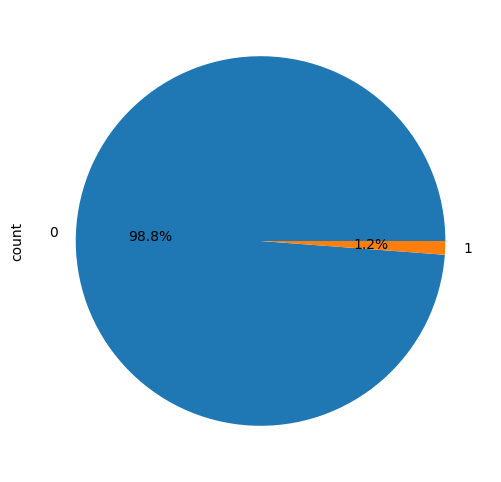

In [14]:
con.close()
df['Fraud'] = (df['location'] == 'Martinview') | (df['title'] == "Clinical biochemist")
df['Fraud'].value_counts()
df['Fraud'] = [1 if X == True else 0 for X in df['Fraud']]

plt.figure(figsize=(10,6))
df['Fraud'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.show()


In [15]:
### Regular Machine Learning for classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
cv = CountVectorizer()


X = df['Text']
y = df['Fraud']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)
from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

pa = PassiveAggressiveClassifier()
gnb = GaussianNB()
lr = LogisticRegression()
GBC= GradientBoostingClassifier()

def evaluate_sklearn_models(X_train,X_test,y_train,y_test,model):
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    clf_rpt = classification_report(y_test,pred)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred,average='micro')
    print(f'Micro-Weighted f1 score of the model: {f1*100:.2f}%')
    print(f'{model.__class__.__name__}, --Classification Report-- {clf_rpt}; --Accuracy-- {acc*100:.2f}')
    return pred


gnb_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, gnb)
lr_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, lr)
pa_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, pa)
GBC_pred = evaluate_sklearn_models(X_train,X_test,y_train,y_test,GBC)



Micro-Weighted f1 score of the model: 98.75%
GaussianNB, --Classification Report--               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1977
           1       0.00      0.00      0.00        23

    accuracy                           0.99      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.98      0.99      0.98      2000
; --Accuracy-- 98.75
Micro-Weighted f1 score of the model: 98.90%
LogisticRegression, --Classification Report--               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1977
           1       1.00      0.04      0.08        23

    accuracy                           0.99      2000
   macro avg       0.99      0.52      0.54      2000
weighted avg       0.99      0.99      0.98      2000
; --Accuracy-- 98.90
Micro-Weighted f1 score of the model: 98.75%
PassiveAggressiveClassifier, --Classification Report--               precision    recal

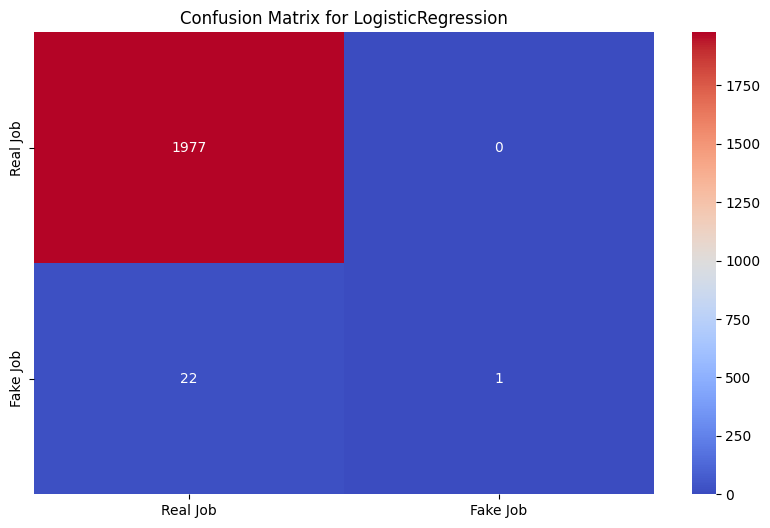

In [16]:
def plot_confusion_matrix(y_true,y_pred,model):
    confmat = confusion_matrix(y_test, y_pred)
    hmap = sns.heatmap(confmat,fmt='d',annot=True,cmap='coolwarm',xticklabels=['Real Job','Fake Job'],yticklabels=['Real Job','Fake Job'])
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()


plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, lr_pred, lr)
plt.show()


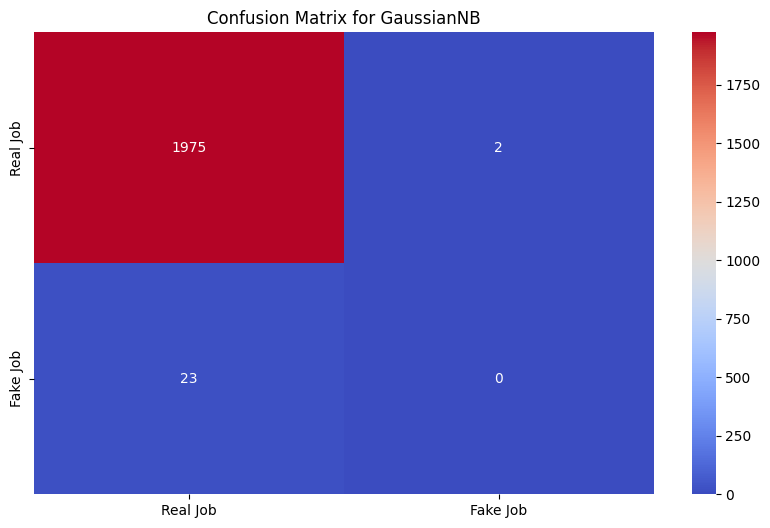

In [17]:
plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, gnb_pred, gnb)
plt.show()

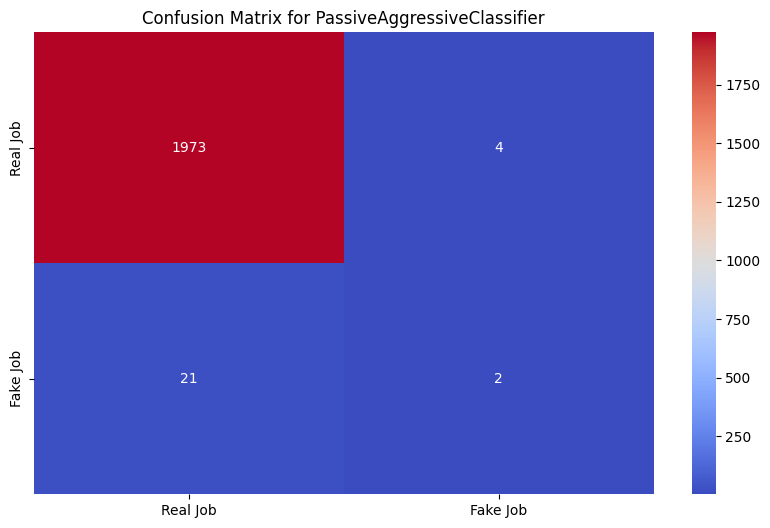

In [18]:

plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, pa_pred, pa)
plt.show()


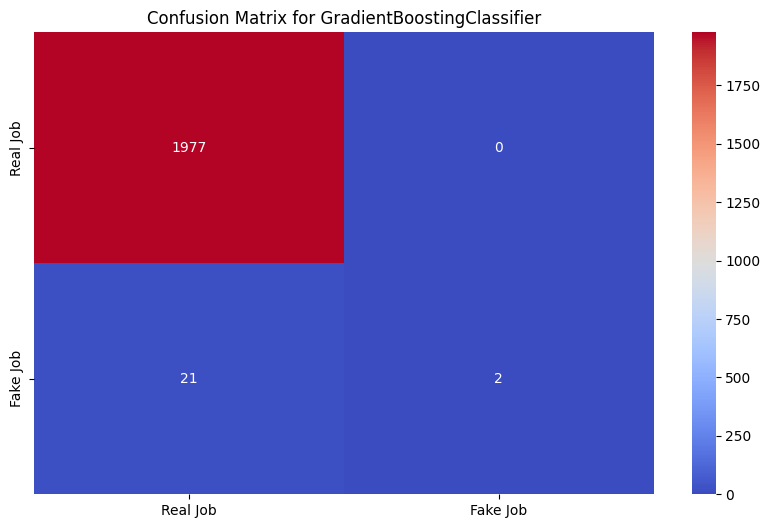

In [19]:
plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test,GBC_pred,GBC)
plt.show()





tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


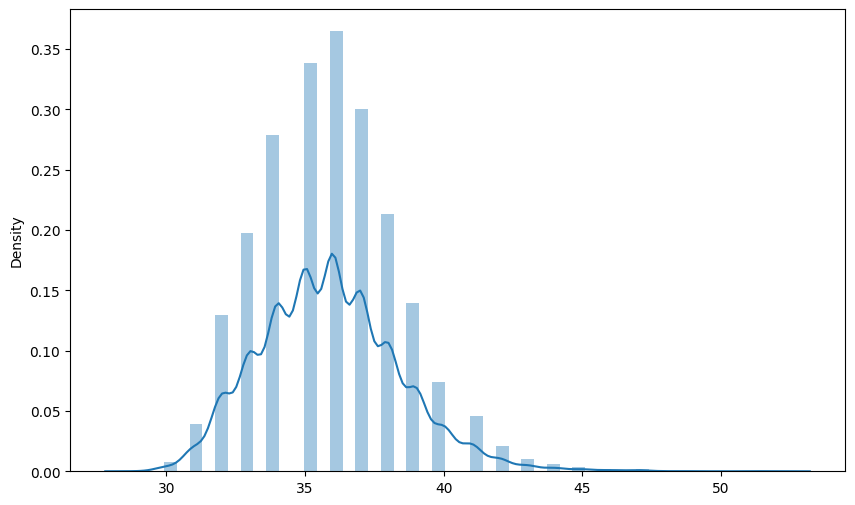

In [20]:
### using only 'Text' and 'Fraud' for Bert


df = df[['Text','Fraud']]



MODEL_NAME = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME,do_lower_case=True)





sample_tokens = []
for txt in df['Text']:
    tokens = tokenizer.encode(txt,max_length=512)
    sample_tokens.append(len(tokens))
    
    
    
plt.figure(figsize=(10,6))
sns.distplot(sample_tokens)
plt.show()



In [21]:

MAX_LEN = 60

class FakeJobsDataset(torch.utils.data.Dataset):
    def __init__(self,Text,targets,max_len,tokenizer):
        self.Text = Text
        self.targets = targets
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.Text)
    
    
    def __getitem__(self,idx):
        Text = str(self.Text[idx])
        target = self.targets[idx]
        
        encoder = self.tokenizer.encode_plus(
            Text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            "Text":Text,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "targets":torch.tensor(target,dtype=torch.long)
            }



from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=.10,random_state=42)




def get_dataloader(df,max_len,tokenizer,batch_size):
    ds = FakeJobsDataset(
        Text = df['Text'].to_numpy(),
        targets = df['Fraud'].to_numpy(),
        max_len=max_len,
        tokenizer=tokenizer
        )
    return torch.utils.data.DataLoader(
        ds,
        num_workers=0,
        batch_size=batch_size
        )



BATCH_SIZE = 16
learning_rate = 1e-5
train_dataloader = get_dataloader(df_train, max_len=MAX_LEN, tokenizer=tokenizer, batch_size=BATCH_SIZE)
test_dataloader = get_dataloader(df_test, max_len=MAX_LEN, tokenizer=tokenizer, batch_size=BATCH_SIZE)


data = next(iter(train_dataloader))
data.keys()

dict_keys(['Text', 'input_ids', 'attention_mask', 'targets'])

In [22]:
data['input_ids'].shape,data['attention_mask'].shape,data['targets'].shape

(torch.Size([16, 60]), torch.Size([16, 60]), torch.Size([16]))

In [23]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


bert_model = BertModel.from_pretrained(MODEL_NAME)







class Bert_Classifier(nn.Module):
    def __init__(self, n_classes=2):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(768,2)
    

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)



model = Bert_Classifier(2)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi